In [ ]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import gc
import pandas as pd
import datetime as dt
import dask
from datetime import datetime
import matplotlib.pyplot as plt
import os
import s3fs
import zarr
import geocat.comp
import xesmf as xe

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from math import e
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
from sklearn import metrics
from keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.layers import BatchNormalization
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping

from keras.regularizers import l2
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score
from keras.constraints import unit_norm


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
#Preprocessing functions
#3D detrend function
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
    
#1D detrend function
def altdetrend(x:np.ndarray,time:np.ndarray):
        nt = x.shape
        xtemp = x.reshape(nt)
        p = np.polyfit(time, x, deg=1)
        fit = p[0]*(time[:,np.newaxis])+ p[1]
        return x - fit.reshape(nt)
    
def remove_time_mean(x):
        return x - x.mean(dim='time')

def removeSC(x):
        return x.groupby('time.month').apply(remove_time_mean)

# Calculate std normal anomaly
def calStdNorAnom(x):
    a=[]
    for m in np.unique(x.time.dt.month):
        mData=x[x.time.dt.month==m]
        mRolling=mData.rolling(time=31, center=True).mean().bfill(dim="time").ffill(dim="time")
        sRolling=mData.rolling(time=31, center=True).std().bfill(dim="time").ffill(dim="time")
        normData=(mData-mRolling)/sRolling
        a.append(normData)
    combineArray=xr.concat(a,'time')
    outArray=combineArray.sortby('time')
    return outArray

In [ ]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)
## By downloading the master CSV file enumerating all available data stores, we can interact with the spreadsheet
## through a pandas DataFrame to search and explore for relevant data using the CMIP6 controlled vocabulary:
df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

In [ ]:
def getData(qstring):
    df_subset = df.query(qstring)
    if df_subset.empty:
        print('data not available for '+qstring)
    else:
        for v in df_subset.zstore.values:
            zstore = v
            mapper = fs.get_mapper(zstore)
            return_ds = xr.open_zarr(mapper, consolidated=True)
    return(return_ds)

In [ ]:
#Open CESM2 Ensemble Datasets
modelName="'CESM2'"
institute="'NCAR'"
expList=["'historical'"]
actList=["'CMIP'"]
membList=["'r1i1p1f1'", "'r2i1p1f1'", "'r3i1p1f1'", "'r4i1p1f1'" , "'r5i1p1f1'", "'r6i1p1f1'", "'r7i1p1f1'","'r8i1p1f1'","'r9i1p1f1'","'r10i1p1f1'","'r11i1p1f1'"]

In [7]:
creslist=[]
crellist=[]
netTOAcslist=[]
dummy_ylist=[]

for j,memb in enumerate(membList):
        inputStr  = "institution_id =='NCAR' & source_id=='CESM2' & table_id=='Amon' & experiment_id=='historical' &  member_id=="+memb+" & variable_id=="
        altinputStr  = "activity_id=='CMIP' & table_id=='fx' & source_id=='CESM2' & experiment_id=='historical' &  member_id=="+memb+" & variable_id=="
        rsut_ds   = getData(inputStr+"'rsut'")
        pr_ds     = getData(inputStr+"'pr'")
        rsutcs_ds = getData(inputStr+"'rsutcs'")
        sftlf_ds = getData(altinputStr+"'sftlf'")
        rlut_ds   =getData(inputStr+"'rlut'")
        rlutcs_ds  =getData(inputStr+"'rlutcs'")
        rsdt_ds  =getData(inputStr+"'rsdt'")
        
        netTOAcs = rsdt_ds.rsdt - rsutcs_ds.rsutcs - rlutcs_ds.rlutcs
        cres= rsutcs_ds.rsutcs-rsut_ds.rsut
        crel=rlutcs_ds.rlutcs-rlut_ds.rlut
        prec=pr_ds.pr
        land=sftlf_ds.sftlf
        
        regridtarget=cres
    
        datetimeindex=cres.indexes['time'].to_datetimeindex()
        cres['time']=datetimeindex
        crel['time']=datetimeindex
        netTOAcs['time']=datetimeindex
        prec['time']=datetimeindex
        
        cres,land= xr.broadcast(cres,land) #add time dimension to land variable for compatability with CRE variables
        
        
        months=[6,7,8,9]
        leadmonths=[6,7,8,9]
        #months=[6]
        #leadmonths=[6]

        #varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
        prec=prec.sel(time=prec.time.dt.month.isin(months))
        cres=cres.sel(time=cres.time.dt.month.isin(leadmonths))
        crel=crel.sel(time=crel.time.dt.month.isin(leadmonths))
        netTOAcs=netTOAcs.sel(time=netTOAcs.time.dt.month.isin(leadmonths))
        land=land.sel(time=land.time.dt.month.isin(months))
        
        #Select only the SAM lat,lon range: 60-100E, 10-30N
        precip=prec.sel(lon=slice(60,100),lat=slice(10,30))
        land=land.sel(lon=slice(60,100),lat=slice(10,30))
        
        #Expand region of CRE exlusion to 50-110lon and 0-40lat in training to force model to see teleconnections
        cres=xr.where((cres.lat>0) & (cres.lat<40) & (cres.lon>50) & (cres.lon<110),0,cres)
        crel=xr.where((crel.lat>0) & (crel.lat<40) & (crel.lon>50) & (crel.lon<110),0,crel)
        netTOAcs=xr.where((netTOAcs.lat>0) & (netTOAcs.lat<40) & (netTOAcs.lon>50) & (netTOAcs.lon<110),0,netTOAcs)
        
        cres=cres.transpose('time','lat','lon')
        crel=crel.transpose('time','lat','lon')
        netTOAcs=netTOAcs.transpose('time','lat','lon')
        
        precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 
        
        #Do weighted correction on precipitation
        weights=np.cos(np.deg2rad(precip.lat))
        prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
        prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m
        
        lat=cres.lat
        lon=cres.lon
        
        #Do the preprocessing
        cres=removeSC(cres)
        cres=calStdNorAnom(cres)
        
        crel=removeSC(crel)
        crel=calStdNorAnom(crel)
        
        netTOAcs=removeSC(netTOAcs)
        netTOAcs=calStdNorAnom(netTOAcs)
        
        #Detrend
        time=cres.time
        cres=cres.to_numpy()
        crel=crel.to_numpy()
        netTOAcs=netTOAcs.to_numpy()
        time=time.to_numpy()
        time=time.astype(int)/10**9
        
        cres=detrend(cres,time)
        cres=xr.DataArray(cres,coords=[time,lat,lon],dims=['time','lat','lon'])
        
        crel=detrend(crel,time)
        crel=xr.DataArray(crel,coords=[time,lat,lon],dims=['time','lat','lon'])
        
        netTOAcs=detrend(netTOAcs,time)
        netTOAcs=xr.DataArray(netTOAcs,coords=[time,lat,lon],dims=['time','lat','lon'])
        
        #0's in original data become nan in preprocessing so replace them back with 0
        cres=cres.fillna(0)
        crel=crel.fillna(0)
        netTOAcs=netTOAcs.fillna(0)
        
        #Precip preprocessing
        #Remove seasonal cycle
        prec_index=removeSC(prec_index)
        
        #Normalize
        prec_index=calStdNorAnom(prec_index)
        
        #Detrend
        time=prec_index.time
        prec_index=prec_index.to_numpy()
        time=time.to_numpy()
        time=time.astype(int)/10**9
        
        prec_index=altdetrend(prec_index,time)
        prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])
        
        
        mysd=prec_index.std()
        mymean=prec_index.mean()

        buckets=pd.Categorical(pd.cut(prec_index, [mymean - mysd* 10000,  mymean - 0.5*mysd,  mymean + 0.5*mysd, mymean + mysd* 10000])).rename_categories(['low','average','high'])

        le = preprocessing.LabelEncoder()
        le.fit(buckets)

        labelprec=le.transform(buckets)

        # convert integers to dummy variables (i.e. one hot encoded)
        nclasses=3
        dummy_y=to_categorical(labelprec,nclasses) #converts to binary
        
        creslist.append(cres)
        cresstack=np.stack(creslist,axis=0)
        
        crellist.append(crel)
        crelstack=np.stack(crellist,axis=0)
        
        netTOAcslist.append(netTOAcs)
        netTOAcsstack=np.stack(netTOAcslist,axis=0)
        
        dummy_ylist.append(dummy_y)
        dummy_ystack=np.stack(dummy_ylist,axis=0)
              

In [8]:
#Seperate each cres array
cresIn1=cresstack[0,:,:,:]
cresIn2=cresstack[1,:,:,:]
cresIn3=cresstack[2,:,:,:]
cresIn4=cresstack[3,:,:,:]
cresIn5=cresstack[4,:,:,:]
cresIn6=cresstack[5,:,:,:]
cresIn7=cresstack[6,:,:,:]
cresIn8=cresstack[7,:,:,:]
cresIn9=cresstack[8,:,:,:]
cresIn10=cresstack[9,:,:,:]
cresIn11=cresstack[10,:,:,:]


#Concatenate the ensemble members along time axis
cresIn=np.concatenate((cresIn1,cresIn2,cresIn3,cresIn4,cresIn5,cresIn6,cresIn7,cresIn8,cresIn9,cresIn10,cresIn11),axis=0)

#Seperate each crel array
crelIn1=crelstack[0,:,:,:]
crelIn2=crelstack[1,:,:,:]
crelIn3=crelstack[2,:,:,:]
crelIn4=crelstack[3,:,:,:]
crelIn5=crelstack[4,:,:,:]
crelIn6=crelstack[5,:,:,:]
crelIn7=crelstack[6,:,:,:]
crelIn8=crelstack[7,:,:,:]
crelIn9=crelstack[8,:,:,:]
crelIn10=crelstack[9,:,:,:]
crelIn11=crelstack[10,:,:,:]

#Concatenate the ensemble members along time axis
crelIn=np.concatenate((crelIn1,crelIn2,crelIn3,crelIn4,crelIn5,crelIn6,crelIn7,crelIn8,crelIn9,crelIn10,crelIn11),axis=0)

#Seperate each netTOAcs array
netTOAcsIn1=netTOAcsstack[0,:,:,:]
netTOAcsIn2=netTOAcsstack[1,:,:,:]
netTOAcsIn3=netTOAcsstack[2,:,:,:]
netTOAcsIn4=netTOAcsstack[3,:,:,:]
netTOAcsIn5=netTOAcsstack[4,:,:,:]
netTOAcsIn6=netTOAcsstack[5,:,:,:]
netTOAcsIn7=netTOAcsstack[6,:,:,:]
netTOAcsIn8=netTOAcsstack[7,:,:,:]
netTOAcsIn9=netTOAcsstack[8,:,:,:]
netTOAcsIn10=netTOAcsstack[9,:,:,:]
netTOAcsIn11=netTOAcsstack[10,:,:,:]

#Concatenate the ensemble members along time axis
netTOAcsIn=np.concatenate((netTOAcsIn1,netTOAcsIn2,netTOAcsIn3,netTOAcsIn4,netTOAcsIn5,netTOAcsIn6,netTOAcsIn7,netTOAcsIn8,netTOAcsIn9,netTOAcsIn10,netTOAcsIn11),axis=0)

#Seperate each precip_index array
yIn1=dummy_ystack[0,:,:]
yIn2=dummy_ystack[1,:,:]
yIn3=dummy_ystack[2,:,:]
yIn4=dummy_ystack[3,:,:]
yIn5=dummy_ystack[4,:,:]
yIn6=dummy_ystack[5,:,:]
yIn7=dummy_ystack[6,:,:]
yIn8=dummy_ystack[7,:,:]
yIn9=dummy_ystack[8,:,:]
yIn10=dummy_ystack[9,:,:]
yIn11=dummy_ystack[10,:,:]

#Concatenate the ensemble members along time axis
yIn=np.concatenate((yIn1,yIn2,yIn3,yIn4,yIn5,yIn6,yIn7,yIn8,yIn9,yIn10,yIn11),axis=0)

In [9]:
# prepare Data for CNN
cres_train, cres_test, crel_train, crel_test, netTOAcs_train, netTOAcs_test, y_train, y_test = train_test_split(cresIn, crelIn, netTOAcsIn, yIn, stratify=yIn, test_size=0.2, random_state=42)

#Add extra dimension to data, required for algorithm
crestrain=cres_train[:,:,:,None]
creltrain=crel_train[:,:,:,None]
netTOAcstrain=netTOAcs_train[:,:,:,None]

#---------------------------------------------------------
crestest=cres_test[:,:,:,None]
creltest=crel_test[:,:,:,None]
netTOAcstest=netTOAcs_test[:,:,:,None]

X_test=np.array([crestest,creltest,netTOAcstest])
X_train=np.array([crestrain,creltrain,netTOAcstrain])

print(X_train.shape)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

# check for nan
np.isnan(X_test_reshape).any()


(3, 5808, 192, 288, 1)


False

In [10]:
print(y_train.shape)

(5808, 3)


In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #To be compatable with CUDA

In [12]:
# Fit model to training data
# # define 10-fold cross validation test harness

acc_per_fold = []
loss_per_fold = []
fold_no = 1

#To limit memory usage and avoid resource exhaustion
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  


kfold = KFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(8, kernel_size=3, activation='relu', padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(padding='same'))
    cnn3.add(Dropout(rate=0.2))
    
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(padding='same'))
    cnn3.add(Dropout(rate=0.2))
    
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(padding='same'))
    cnn3.add(Dropout(rate=0.2))
    

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    
    cnn3.add(Flatten())
    
    
    #Dense function adds a fully connected layer
    #Hidden layer
    cnn3.add(Dense(128, activation='relu'))
    #Output layer
    cnn3.add(Dense(units= 3, activation = 'softmax')) #units is always equal to number of classes
    
    adam = keras.optimizers.Adam(lr=0.0001) # learning_rate
    #Adam-A optimizer method for Stochastic Optimization
    cnn3.compile(optimizer=adam, loss='categorical_crossentropy',  metrics=['accuracy'])
    epochs=50 # best average accuracy and lowest loss in validation data (cross-validation)
    hist = cnn3.fit(X_train_reshape[train], y_train[train],  batch_size=100, epochs=epochs, verbose=1, shuffle=True, callbacks=[es], 
                         validation_data=(X_train_reshape[test], y_train[test]))
    
    # report performance
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn3.metrics_names[0]} of {scores[0]}; {cnn3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1
    
    #To prevent resource exhaustion
    gc.collect()
    K.clear_session()

Epoch 1/50
53/53 [==============================] - 13s 167ms/step - loss: 1.0094 - accuracy: 0.4549 - val_loss: 0.9411 - val_accuracy: 0.5370
Epoch 2/50
53/53 [==============================] - 7s 133ms/step - loss: 0.8641 - accuracy: 0.5774 - val_loss: 0.8684 - val_accuracy: 0.5697
Epoch 3/50
53/53 [==============================] - 7s 133ms/step - loss: 0.7925 - accuracy: 0.6262 - val_loss: 0.8526 - val_accuracy: 0.5921
Epoch 4/50
53/53 [==============================] - 7s 134ms/step - loss: 0.7376 - accuracy: 0.6549 - val_loss: 0.8179 - val_accuracy: 0.5972
Epoch 5/50
53/53 [==============================] - 7s 136ms/step - loss: 0.7037 - accuracy: 0.6744 - val_loss: 0.8962 - val_accuracy: 0.5818
Epoch 6/50
53/53 [==============================] - 8s 147ms/step - loss: 0.6856 - accuracy: 0.6866 - val_loss: 0.7840 - val_accuracy: 0.6196
Epoch 7/50
53/53 [==============================] - 8s 142ms/step - loss: 0.6442 - accuracy: 0.7002 - val_loss: 0.7939 - val_accuracy: 0.6196
Epoch

In [13]:
pred = cnn3.predict((X_train_reshape), batch_size=10)

In [14]:
pred.shape

(5808, 3)

In [15]:
predicted = np.argmax ( pred , axis=-1 )

In [16]:
print(predicted)
y_true=np.argmax (y_train , axis=-1 )
print(y_true)

cnt=0
for i,p in enumerate(predicted):
    if (p==y_true[i]):
        cnt=cnt+1

#print(cnt, 'out of 1452')
print(cnt, 'out of 5808')

[0 0 2 ... 0 0 0]
[2 0 2 ... 0 0 0]
5340 out of 5808


In [17]:
pred_test = cnn3.predict(X_test_reshape, batch_size=10)
ytestPred=np.argmax ( pred_test , axis=-1 )
ytruePred=np.argmax ( y_test , axis=-1 )
print(ytestPred)
print(ytruePred)

cnt=0
for i,p in enumerate(ytestPred):
    if (p==ytruePred[i]):
        cnt=cnt+1

#print(cnt,'out of 363')
print(cnt,'out of 1452')

[2 2 2 ... 1 2 0]
[2 2 2 ... 0 0 0]
947 out of 1452


In [18]:
#Print the confusion matrix
#print(metrics.confusion_matrix(ytestPred,ytruePred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(ytestPred,ytruePred, digits=3))

              precision    recall  f1-score   support

           0      0.559     0.543     0.551       543
           1      0.722     0.738     0.730       458
           2      0.689     0.696     0.692       451

    accuracy                          0.652      1452
   macro avg      0.657     0.659     0.658      1452
weighted avg      0.651     0.652     0.651      1452



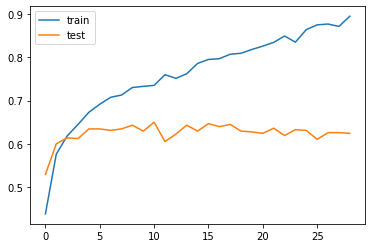

In [19]:
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [20]:
lat=cres.lat
lon=cres.lon

In [21]:
time=X_test_reshape[:,0,0,0,0]

In [22]:
variables=X_test_reshape[0,:,0,0,0]

In [23]:
extra=X_test_reshape[0,0,0,0,:]

###### 

In [24]:
X_test_reshape.shape

(1452, 3, 192, 288, 1)

In [25]:
newXtest=xr.DataArray(X_test_reshape,coords=[time,variables,lat,lon,extra],dims=['time','variables','lat','lon','extra'])

In [156]:
block=xr.where((newXtest.lat>0) & (newXtest.lat<50) & (newXtest.lon>30) & (newXtest.lon<60),0,newXtest)
#block=xr.where((newXtest.lat>-90) & (newXtest.lat<-60),0,newXtest)
#block=xr.where((newXtest.lon>330) & (newXtest.lon<360),0,newXtest)

In [157]:
block.shape

(192, 288, 1452, 3, 1)

In [158]:
block=block.transpose('time','variables','lat','lon','extra')
block.shape

(1452, 3, 192, 288, 1)

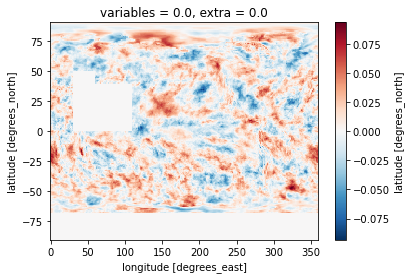

In [159]:
what=block[:,0,:,:,0]
huh=what.mean(axis=0)
huh.plot()

In [160]:
pred_test = cnn3.predict(block, batch_size=10)
ytestPred=np.argmax ( pred_test , axis=-1 )
ytruePred=np.argmax ( y_test , axis=-1 )
print(ytestPred)
print(ytruePred)

cnt=0
for i,p in enumerate(ytestPred):
    if (p==ytruePred[i]):
        cnt=cnt+1

#print(cnt,'out of 363')
print(cnt,'out of 1452')

[0 0 2 ... 1 2 0]
[2 2 2 ... 0 0 0]
868 out of 1452


In [161]:
#Print the confusion matrix
#print(metrics.confusion_matrix(ytestPred,ytruePred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(ytestPred,ytruePred, digits=3))

              precision    recall  f1-score   support

           0      0.644     0.480     0.550       709
           1      0.673     0.677     0.675       465
           2      0.467     0.766     0.580       278

    accuracy                          0.598      1452
   macro avg      0.595     0.641     0.602      1452
weighted avg      0.619     0.598     0.596      1452



In [176]:
#Use ERA5 Data to validate what the AI has learned
#Open ERA5 Datasets
data=xr.open_dataset('ERA5_Input_Exp8.nc')
#Load in preprocessed data
ERAcres=data.cres_pre
ERAnetTOAcs=data.netTOAcs_pre
ERAcrel=data.crel_pre
ERAland=data.lsMask

data1=xr.open_dataset('ERA5_Output_PrecipCon.nc')
ERApr=data1.pr

lat=regridtarget.lat
lon=regridtarget.lon

#Select Monsoon Months
months=[6,7,8,9]
leadmonths=[6,7,8,9]

#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
ERApr=ERApr.sel(time=ERApr.time.dt.month.isin(months))
ERAcres=ERAcres.sel(time=ERAcres.time.dt.month.isin(leadmonths))
ERAnetTOAcs=ERAnetTOAcs.sel(time=ERAnetTOAcs.time.dt.month.isin(leadmonths))
ERAcrel=ERAcrel.sel(time=ERAcrel.time.dt.month.isin(leadmonths))
ERAland=ERAland.sel(time=ERAland.time.dt.month.isin(leadmonths))

ERAcres=xr.where((ERAcres.lat>0) & (ERAcres.lat<40) & (ERAcres.lon>50) & (ERAcres.lon<110),0,ERAcres)
ERAcrel=xr.where((ERAcrel.lat>0) & (ERAcrel.lat<40) & (ERAcrel.lon>50) & (ERAcrel.lon<110),0,ERAcrel)
ERAnetTOAcs=xr.where((ERAnetTOAcs.lat>0) & (ERAnetTOAcs.lat<40) & (ERAnetTOAcs.lon>50) & (ERAnetTOAcs.lon<110),0,ERAnetTOAcs)

ERAcres=ERAcres.transpose('time','lat','lon')
ERAcrel=ERAcrel.transpose('time','lat','lon')
ERAnetTOAcs=ERAnetTOAcs.transpose('time','lat','lon')

time=ERAcres.time

#regrid data to CESM grid
ds_target = xr.Dataset({'time':(['time'],time.data),'lat':(['lat'],lat.data),'lon':(['lon'],lon.data)})

regridder = xe.Regridder(ERAcres,ds_target,'bilinear',periodic=True)

regridcres = regridder(ERAcres)
ERAcres=xr.DataArray(regridcres,coords=[time,lat,lon],dims=['time','lat','lon'])

regridcrel=regridder(ERAcrel)
ERAcrel=xr.DataArray(regridcrel,coords=[time,lat,lon],dims=['time','lat','lon'])

regridnetTOAcs=regridder(ERAnetTOAcs)
ERAnetTOAcs=xr.DataArray(regridnetTOAcs,coords=[time,lat,lon],dims=['time','lat','lon'])

regridpr=regridder(ERApr)
ERApr=xr.DataArray(regridpr,coords=[time,lat,lon],dims=['time','lat','lon'])

regridland=regridder(ERAland)
ERAland=xr.DataArray(regridland,coords=[time,lat,lon],dims=['time','lat','lon'])



In [177]:
#Select only the SAM lat,lon range: 60-100E, 10-30N
precip=ERApr.sel(lon=slice(60,100),lat=slice(10,30))
land=ERAland.sel(lon=slice(60,100),lat=slice(10,30))

precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

In [178]:
#Remove seasonal cycle
prec_index=removeSC(prec_index)

In [179]:
#Normalize
prec_index=calStdNorAnom(prec_index)

In [180]:
#Detrend
time=prec_index.time
prec_index=prec_index.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

prec_index=altdetrend(prec_index,time)
prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])


In [181]:
mysd=prec_index.std()
mymean=prec_index.mean()

buckets=pd.Categorical(pd.cut(prec_index, [mymean - mysd* 10000,  mymean - 0.5*mysd,  mymean + 0.5*mysd, mymean + mysd* 10000])).rename_categories(['low','average','high'])

le = preprocessing.LabelEncoder()
le.fit(buckets)
high=buckets=='high'
average=buckets=='average'
low=buckets=='low'
print(len(np.where(high)[0]),'high')
print(len(np.where(average)[0]),'average')
print(len(np.where(low)[0]),'low')

labelprec=le.transform(buckets)

# convert integers to dummy variables (i.e. one hot encoded)
#nclasses=7
nclasses=3
dummy_y=to_categorical(labelprec,nclasses) #converts to binary

81 high
88 average
83 low


In [182]:
#Add extra dimension to data, required for algorithm
crestest=ERAcres.values
crestest=crestest[:,:,:,None]

creltest=ERAcrel.values
creltest=creltest[:,:,:,None]

netTOAcstest=ERAnetTOAcs.values
netTOAcstest=netTOAcstest[:,:,:,None]

X_test=np.array([crestest,creltest,netTOAcstest])

print(X_test.shape)


X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

# check for nan
np.isnan(X_test_reshape).any()


(3, 252, 192, 288, 1)


False

In [183]:
pred = cnn3.predict((X_test_reshape), batch_size=10)

In [184]:
predicted = np.argmax ( pred , axis=-1 )

In [185]:
print(predicted)
y_true=np.argmax (dummy_y , axis=-1 )
print(y_true)

cnt=0
for i,p in enumerate(predicted):
    if (p==y_true[i]):
        cnt=cnt+1

print(cnt, 'out of 252')

[2 2 2 2 2 2 2 2 1 2 0 2 0 0 1 0 1 2 2 2 1 1 0 0 1 2 2 2 1 2 2 2 2 0 2 2 1
 2 2 2 2 0 0 2 2 2 0 0 1 0 2 2 2 2 2 2 0 1 0 1 2 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 2 2 1 1 0 0 2 0 0 2 0 2 2 1 2 0 0 1 1 0 0 2 0 0 1 0 0 0 0 2
 2 2 2 0 0 2 0 0 0 1 2 2 0 0 0 0 2 1 0 2 2 2 0 2 0 0 0 0 1 1 1 1 2 2 0 0 2
 1 0 1 0 2 0 2 0 0 0 0 0 0 2 0 0 0 2 0 1 0 0 2 0 2 2 0 2 0 1 0 0 2 0 2 0 0
 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 0 0 2 0 1 1 1 0 0 0 0 0 0 0 2 1 1 1 0 0 0
 1 0 1 0 2 2 1 0 2 2 0 0 0 0 1 0 0 0 2 0 1 1 1 0 1 0 0 1 0 1]
[0 1 0 1 2 1 0 0 0 0 1 1 2 0 1 0 1 0 1 2 0 1 1 1 1 1 0 2 1 1 1 0 2 1 1 1 1
 1 2 0 2 0 2 2 1 2 1 1 1 0 0 2 2 2 2 2 1 0 1 0 2 0 2 2 0 0 0 1 0 0 1 2 2 0
 2 2 0 0 0 0 2 2 2 2 1 2 2 2 2 2 2 2 0 2 0 2 2 2 1 1 1 0 0 2 0 0 2 0 0 0 2
 2 2 2 0 0 2 1 1 1 0 1 2 1 1 1 1 1 1 0 1 2 2 0 0 2 0 2 2 1 1 1 1 2 0 0 0 1
 1 0 0 0 2 1 0 0 0 0 0 0 0 2 2 2 1 2 2 2 1 2 2 2 0 2 0 2 1 1 2 1 0 2 2 2 2
 0 2 1 2 0 0 0 1 1 0 1 1 0 1 0 2 1 0 0 0 1 1 1 1 2 1 1 2 0 0 1 1 1 0 0 2 2
 0 0 0 0 2 2 0 1 2 0 0 1 0 0 0 0 1 2 2

In [186]:
print(metrics.classification_report(y_true,predicted, digits=3))

              precision    recall  f1-score   support

           0      0.415     0.580     0.483        88
           1      0.549     0.346     0.424        81
           2      0.526     0.494     0.509        83

    accuracy                          0.476       252
   macro avg      0.496     0.473     0.472       252
weighted avg      0.494     0.476     0.473       252



# Change to sheet 4 on google sheets

# Models 1,2,3 (change epochs)

In [ ]:
# Fit model to training data

acc_per_fold = []
loss_per_fold = []
fold_no = 1


#To limit memory usage and avoid resource exhaustion
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  
        
# Define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Dropout(rate = 0.1))
    
    
    cnn3.add(Flatten())
    
    
    #Dense function adds a fully connected layer
    #Hidden layer
    cnn3.add(Dense(16, activation='relu'))
    cnn3.add(Dropout(rate = 0.1))
    #Output layer
    cnn3.add(Dense(units= nclasses, activation = "softmax")) #units is always equal to number of classes
    
    
    adam = keras.optimizers.Adam(lr=0.0001) # learning_rate
    #Adam-A optimizer method for Stochastic Optimization
    cnn3.compile(optimizer=adam, loss='categorical_crossentropy',  metrics=['accuracy'])
    epochs=10 # best average accuracy and lowest loss in validation data (cross-validation)
        
    hist = cnn3.fit(X_train_reshape[train], y_train[train],  epochs=epochs, batch_size=10, verbose=1, shuffle=True,
                         validation_data=(X_train_reshape[test], y_train[test]))
    
    # report performance
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn3.metrics_names[0]} of {scores[0]}; {cnn3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    #To prevent resource exhaustion
    gc.collect()
    K.clear_session()
    



# Models 4, 5

In [ ]:
# Fit model to training data
# # define 10-fold cross validation test harness

acc_per_fold = []
loss_per_fold = []
fold_no = 1

#To limit memory usage and avoid resource exhaustion
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  

kfold = KFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(8, kernel_size=3, activation='relu', padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(BatchNormalization())
    cnn3.add(AveragePooling3D(padding='same'))
    #cnn3.add(Dropout(rate=0.2))
    
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(BatchNormalization())
    cnn3.add(AveragePooling3D(padding='same'))
    #cnn3.add(Dropout(rate=0.2))
    

    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
    
    cnn3.add(Flatten())
    
    
    #Dense function adds a fully connected layer
    #Hidden layer
    cnn3.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l=1e-5)))
    #Output layer
    cnn3.add(Dense(units= 3, activation = 'softmax')) #units is always equal to number of classes
    
    adam = keras.optimizers.Adam(lr=0.00001) # learning_rate
    sgd=keras.optimizers.SGD(lr=0.0001)
    #Adam-A optimizer method for Stochastic Optimization
    cnn3.compile(optimizer=adam, loss='categorical_crossentropy',  metrics=['accuracy'])
    epochs=75 # best average accuracy and lowest loss in validation data (cross-validation)
    hist = cnn3.fit(X_train_reshape[train], y_train[train],  batch_size=100, epochs=epochs, verbose=1, shuffle=True, #callbacks=[es], 
                         validation_data=(X_train_reshape[test], y_train[test]))
    
    # report performance
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn3.metrics_names[0]} of {scores[0]}; {cnn3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    #To prevent resource exhaustion
    #gc.collect()
    #K.clear_session()

# Model 6

In [ ]:
# Fit model to training data
# # define 10-fold cross validation test harness

acc_per_fold = []
loss_per_fold = []
fold_no = 1

#To limit memory usage and avoid resource exhaustion
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  

kfold = KFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kfold.split(X_train_reshape, y_train):
    
    cnn3 = Sequential()
    cnn3.add(Conv3D(8, kernel_size=3, activation='relu', padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Dropout(rate = 0.4))
    
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Dropout(rate = 0.4))
    
    #cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',  kernel_regularizer=regularizers.l2(l=0.01)))
    #cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    #cnn3.add(Dropout(rate = 0.4))
    
    
    
    cnn3.add(Flatten())
    
    
    #Dense function adds a fully connected layer
    #Hidden layer
    cnn3.add(Dense(8, activation='relu'))
    cnn3.add(Dropout(rate = 0.2))
    #Output layer
    cnn3.add(Dense(units= nclasses, activation = "softmax")) #units is always equal to number of classes
    
    adam = keras.optimizers.Adam(lr=0.0001) # learning_rate
    #sgd=keras.optimizers.SGD(lr=0.0001)
    #adadelta=keras.optimizers.Adadelta(learning_rate=0.001)
    #Adam-A optimizer method for Stochastic Optimization
    cnn3.compile(optimizer=adam, loss='categorical_crossentropy',  metrics=['accuracy'])
    epochs=100 # best average accuracy and lowest loss in validation data (cross-validation)
    hist = cnn3.fit(X_train_reshape[train], y_train[train],  epochs=epochs, batch_size=20, verbose=1, shuffle=True,
                         validation_data=(X_train_reshape[test],y_train[test]))
    
    # report performance
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn3.metrics_names[0]} of {scores[0]}; {cnn3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    #To prevent resource exhaustion
    gc.collect()
    K.clear_session()

# Model 7

In [ ]:
# Fit model to training data
# # define 10-fold cross validation test harness

acc_per_fold = []
loss_per_fold = []
fold_no = 1

#To limit memory usage and avoid resource exhaustion
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  

kfold = KFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu', padding='same',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5),
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Dropout(rate = 0.1))
    
    #cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    #cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    #cnn3.add(Dropout(rate = 0.1))
    
    #cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    #cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    #cnn3.add(Dropout(rate = 0.1))
    
    #cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    #cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    #cnn3.add(Dropout(rate = 0.1))
    
    
    
    cnn3.add(Flatten())
    
    
    #Dense function adds a fully connected layer
    #Hidden layer
    cnn3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    cnn3.add(Dropout(rate = 0.1))
    #Output layer
    cnn3.add(Dense(units= nclasses, activation = "softmax")) #units is always equal to number of classes
    
    
    adam = keras.optimizers.Adam(lr=1e-4) # learning_rate
    #sgd=keras.optimizers.SGD(lr=0.0001)
    #adadelta=keras.optimizers.Adadelta(learning_rate=0.001)
    #Adam-A optimizer method for Stochastic Optimization
    cnn3.compile(optimizer=adam, loss='categorical_crossentropy',  metrics=['accuracy'])
    epochs=100 # best average accuracy and lowest loss in validation data (cross-validation)
    hist = cnn3.fit(X_train_reshape[train], y_train[train],  epochs=epochs, verbose=1, shuffle=True,
                         validation_data=(X_train_reshape[test], y_train[test]))
        
    
    # report performance
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn3.metrics_names[0]} of {scores[0]}; {cnn3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    #To prevent resource exhaustion
    gc.collect()
    K.clear_session()